In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time
import random
from scipy.stats import poisson, norm


In [3]:

# Set random seed for reproducibility
np.random.seed(42)

# Load the data from the specified .npz file
file = np.load("..\\data\\2024-03-29-data.npz")

# Extract the necessary components from the file
data = file['data']               # Raw Data
mz_values = file['mz_values']     # Corresponding mz-values
image_size = file['image_size']   # Size of the image
mz_picks = file['mz_picks']       # Selected mz-ids
num = file['num']                 # Number of picks

In [42]:

def sample_from_matrix(A, ratio_to_keep, seed=42):
    rng = np.random.default_rng(seed)
    num_samples = int(ratio_to_keep * A.size)
    coords = rng.choice(np.arange(A.size), size=num_samples, replace=False)
    coords_TF = np.zeros(A.shape, dtype=bool)
    coords_TF.flat[coords] = True
    X = np.zeros(A.shape)
    X.flat[coords] = A.flat[coords]
        
    
    return X, coords, coords_TF


def sample_from_matrix_ratio(A, ratio_to_keep, seed=42):
    rng = np.random.default_rng(seed)
    num_samples = int(ratio_to_keep * A.size)
    coords = rng.choice(np.arange(A.size), size=num_samples, replace=False)
    coords_TF = np.zeros(A.shape, dtype=bool)
    coords_TF.flat[coords] = True
    X = np.zeros(A.shape)
    X_nans = np.zeros(A.shape)
    X_nans[:] = np.nan
    X_nans.flat[coords] = A.flat[coords]
    X.flat[coords] = A.flat[coords]
    
    return X, coords, coords_TF, X_nans


def normalizeData(data):
    # Normalize the data
    row_max = data.max(axis=1)
    n_data = data / row_max[:, np.newaxis]
    # n_data = n_data.T
    return n_data, row_max

def denormalizeData(n_data, row_max):
    # Denormalize the data
    denormalized_data = n_data * row_max[:, np.newaxis]
    return denormalized_data


def plotHistogram(data, bins='auto'):
    plt.figure(figsize=(15, 10))
    
    # Plotting the histogram of the input data
    plt.hist(data, bins=bins, color='skyblue', edgecolor='black', density=True, label='Data Histogram')
    
    # Generate and plot the selected distribution
    x_values = np.linspace(min(data), max(data), 1000)

    mean = np.mean(data)
    std = np.std(data)
    
    # Calculate the normal PDF
    normal_pdf = norm.pdf(x_values, mean, std)
    plt.plot(x_values, normal_pdf, label=f'Normal Distribution (mean={mean}, std={std})', color='red')

    # Adding labels and title
    plt.xlabel('Values')
    plt.ylabel('Probability')
    plt.legend()

    # Display the plot
    plt.show()

def generate_matrix(mean, std, shape=(4, 4)):
    """
    Generates a matrix of the given shape with values between 0 and 1,
    and specified mean and standard deviation.
    
    Args:
    - mean (float): Desired mean of the matrix.
    - std (float): Desired standard deviation of the matrix.
    - shape (tuple): Shape of the matrix (default is 4x4).
    
    Returns:
    - matrix (numpy array): A matrix with values between 0 and 1, mean and std.
    """
    # Generate a normal distribution with the specified mean and std
    matrix = np.random.normal(loc=mean, scale=std, size=shape)
    
    # Clip the values to ensure they are between 0 and 1
    matrix = np.clip(matrix, 0, 1)
    
    # Verify the mean and std
    print(f"Generated matrix has mean: {np.mean(matrix):.10f} and std: {np.std(matrix):.10f}")
    
    return matrix

def sample_nonzero_values(matrix, sample_ratio):
    """
    Randomly samples a ratio of the non-zero values in the matrix and keeps them,
    while setting the rest of the values to zero.
    
    Args:
    - matrix (numpy array): Input matrix with values.
    - sample_ratio (float): Ratio of non-zero values to keep (between 0 and 1).
    
    Returns:
    - sampled_matrix (numpy array): Matrix with sampled non-zero values.
    """
    # Find the indices of non-zero values in the matrix
    non_zero_indices = np.argwhere(matrix != 0)
    
    # Number of non-zero values to sample
    num_non_zero = len(non_zero_indices)
    num_to_sample = int(np.ceil(sample_ratio * num_non_zero))
    
    # Randomly select indices to keep
    sampled_indices = np.random.choice(np.arange(num_non_zero), size=num_to_sample, replace=False)
    
    # Create a new matrix with all values set to zero initially
    sampled_matrix = np.zeros_like(matrix)
    
    # Retain the sampled values in the new matrix
    for idx in sampled_indices:
        row, col = non_zero_indices[idx]
        sampled_matrix[row, col] = matrix[row, col]
    
    return sampled_matrix

In [28]:
# first do uniformly sampling on all values
def sample_matrix(M, sample_ratio=0.5):
    """
    Randomly sets a specified ratio of elements in matrix M to NaN.

    Args:
    - M (numpy array): The original matrix.
    - sample_ratio (float): The ratio of elements to mask as missing (default 0.5).

    Returns:
    - X (numpy array): A copy of M with randomly sampled entries set to NaN.
    """
    # Ensure the input matrix is a numpy array
    M = np.array(M)
    
    # Create a mask of the same shape as M, with the desired ratio of True (missing) values
    mask = np.random.rand(*M.shape) < sample_ratio
    
    # Create a copy of M to avoid modifying the original matrix
    X = M.copy()
    
    # Apply the mask by setting corresponding elements to NaN
    X[mask] = np.nan
    
    return X

# now clip to remove all the low-intensity values
def clip_matrix(M, threshold=0.5):
    """
    Clips the values in matrix M, setting any value below the given threshold to 0.
    
    Args:
    - M (numpy array): The input matrix (values between 0 and 1).
    - threshold (float): The clipping threshold (default 0.5).
    
    Returns:
    - M_clipped (numpy array): A new matrix with values below the threshold set to 0.
    """
    # Ensure the input matrix is a numpy array
    M = np.array(M)
    
    # Clip values below the threshold by setting them to 0
    M_clipped = np.where(M < threshold, 0, M)
    
    return M_clipped


In [29]:
n_data, row_max = normalizeData(data)

# Testing how many values are non-zero. Quite a lot. But not all. 

for row in range(10):
    time.sleep(0.1)
    r = n_data[row,:]
    
    non_zero_indices = len(np.argwhere(r != 0))   
    print(f'So, {100*non_zero_indices/len(r)}% are non-zero indices')

So, 97.25% are non-zero indices
So, 97.158% are non-zero indices
So, 95.836% are non-zero indices
So, 98.79% are non-zero indices
So, 99.41% are non-zero indices
So, 99.498% are non-zero indices
So, 99.466% are non-zero indices
So, 98.89% are non-zero indices
So, 99.932% are non-zero indices
So, 99.962% are non-zero indices


In [30]:
n_data, row_max = normalizeData(data)

mb = n_data[11,:]
mean = np.mean(mb)
std = np.std(mb)

In [31]:
print(f'mean: {mean}, std: {std}')

mean: 0.16810201108455658, std: 0.06853717565536499


In [38]:
def changeShape(matrix):
    return np.reshape(matrix, matrix.shape[0]*matrix.shape[1])


p= generate_matrix(mean, std, shape=(4, 4))

clippedp = clip_matrix(p,mean)

print(clippedp)

len(clippedp!=0)


Generated matrix has mean: 0.1691232981 and std: 0.0700911749
[[0.18451791 0.         0.27778751 0.19645995]
 [0.24770291 0.19910358 0.         0.2773212 ]
 [0.1825037  0.         0.1916551  0.        ]
 [0.         0.         0.         0.23387429]]


4

In [39]:
print(p)
print(clippedp)
print(sample_nonzero_values(clippedp, sample_ratio=0.5))

[[0.18451791 0.09474299 0.27778751 0.19645995]
 [0.24770291 0.19910358 0.1428971  0.2773212 ]
 [0.1825037  0.05501187 0.1916551  0.04311175]
 [0.15815197 0.11573367 0.10539727 0.23387429]]
[[0.18451791 0.         0.27778751 0.19645995]
 [0.24770291 0.19910358 0.         0.2773212 ]
 [0.1825037  0.         0.1916551  0.        ]
 [0.         0.         0.         0.23387429]]
[[0.18451791 0.         0.         0.        ]
 [0.         0.19910358 0.         0.2773212 ]
 [0.         0.         0.1916551  0.        ]
 [0.         0.         0.         0.23387429]]


In [40]:
sclipped = sample_nonzero_values(clippedp, sample_ratio=0.5)
print(sclipped)

[[0.18451791 0.         0.27778751 0.19645995]
 [0.         0.         0.         0.        ]
 [0.1825037  0.         0.1916551  0.        ]
 [0.         0.         0.         0.        ]]


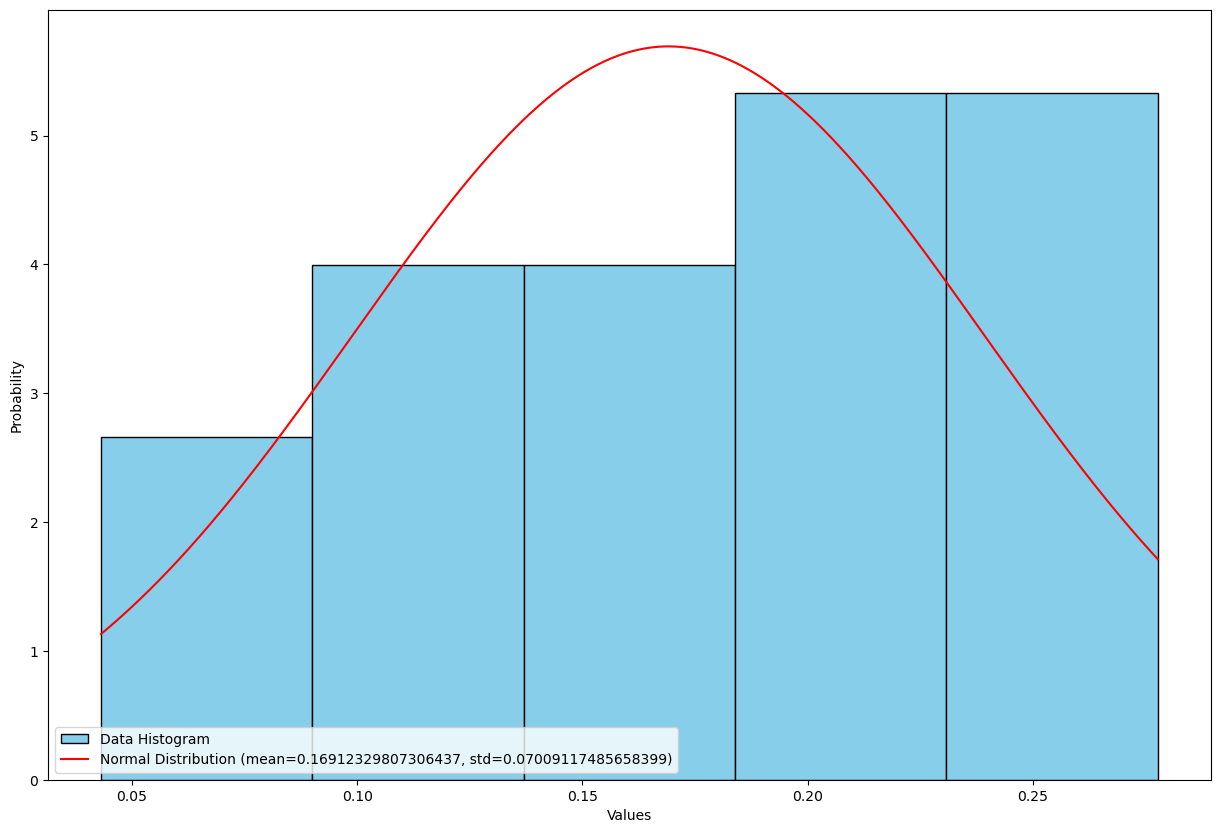

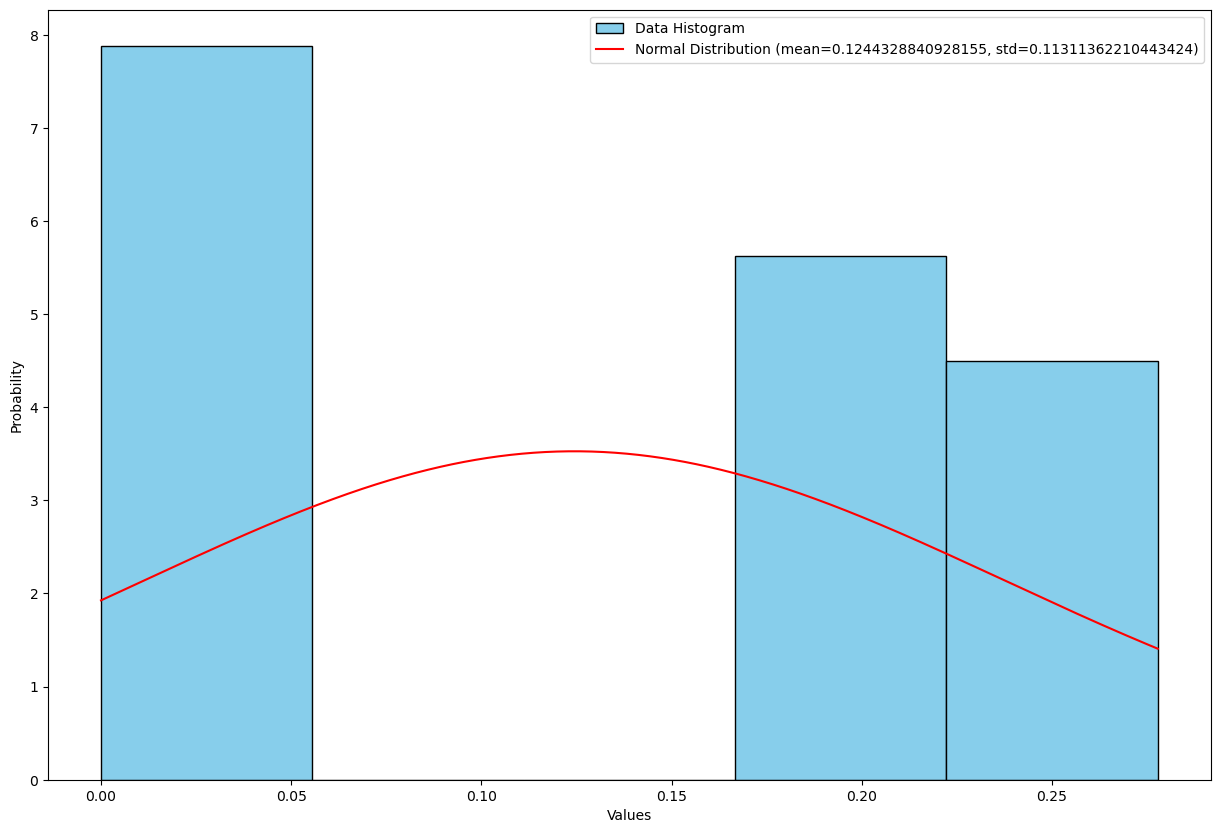

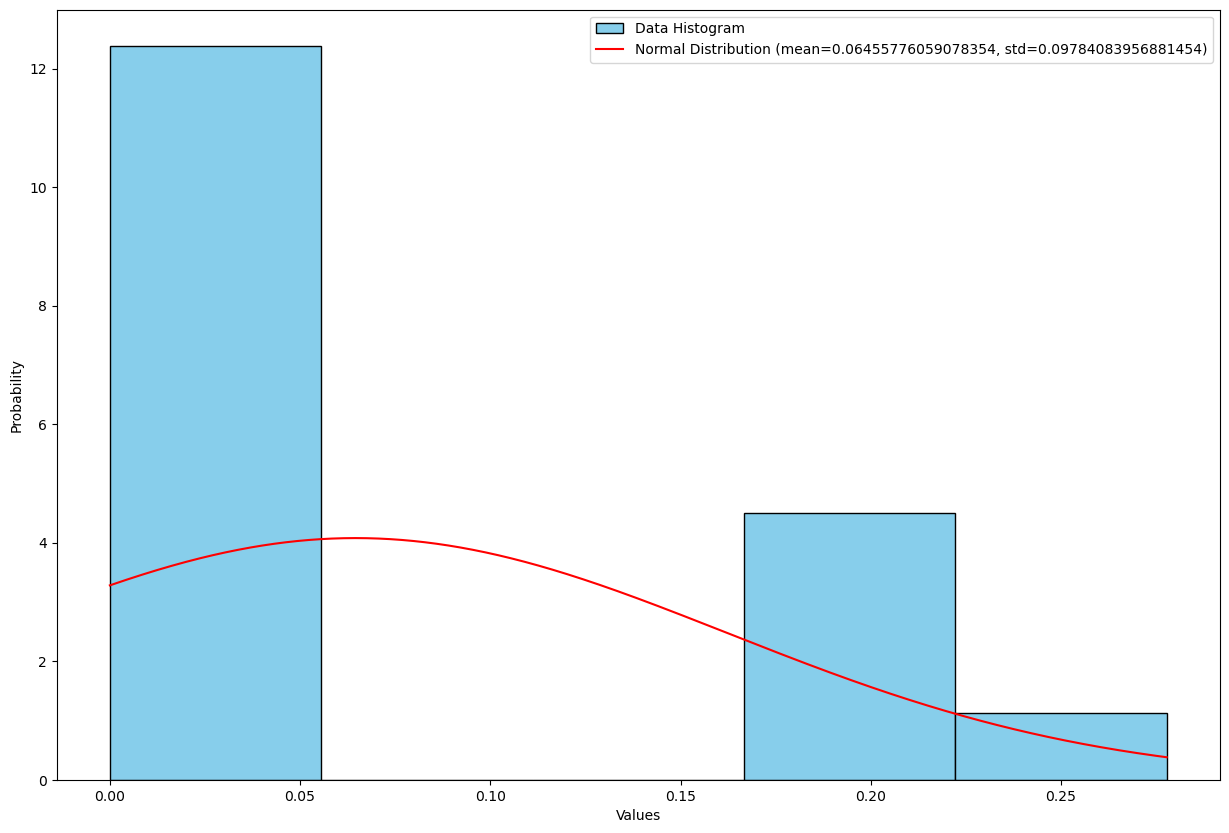

In [43]:
plotHistogram(changeShape(p))
plotHistogram(changeShape(clippedp))
plotHistogram(changeShape(sclipped))

In [9]:
def count_nan(matrix):
    """
    Counts the number of np.nan values in the given matrix.
    
    Args:
    - matrix (numpy array): The matrix in which to count np.nan values.
    
    Returns:
    - count (int): The number of np.nan values in the matrix.
    """
    return np.sum(np.isnan(matrix))


count_nan(sn_data[1,:])

24881

In [10]:
count_nan(sn_data[1,:])/len(sn_data[1,:])

0.49762

In [12]:
X, coords, coords_TF, X_nans = sample_from_matrix_ratio(data, ratio_to_keep=0.6)

In [14]:

def count_zeros(matrix):
    """
    Counts the number of 0 values in the given matrix.
    
    Args:
    - matrix (numpy array): The matrix in which to count 0 values.
    
    Returns:
    - count (int): The number of 0 values in the matrix.
    """
    return np.sum(matrix == 0)

In [16]:
count_zeros(data)/len(data)

1130.056